In [85]:
import numpy as np 
import pandas as pd 
import os
import torch
from torchvision import models
from torchvision.models import ResNet18_Weights
import random
from torch import nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

In [86]:
def quant(B, image, mode:str='train'):
    if mode == "train":
        matrix = np.fromfunction(lambda i, j, k, g: (g+1)/(g+1)*(1/2**B)*random.normalvariate(-0.5, 0.5), (image.shape[0], 512, 16, 16), dtype=float)
        return image+torch.from_numpy(matrix).to('cuda')
    else:
        matrix = np.fromfunction(lambda i, j, k, g: (g+1)/(g+1)*(2**B), (image.shape[0], 512, 16, 16), dtype=float)
        return (image*torch.from_numpy(matrix)+0.5)

In [87]:
class Decoder(nn.Module):
    def __init__(self, B=2):
        super(Decoder, self).__init__()
        self.B=B
        self.upconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2,stride=2)
        self.conv2 = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(256),
                                   nn.ReLU(inplace=True))
        
        self.upconv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2,stride=2)
        self.conv3 = nn.Sequential(nn.Conv2d(128, 128, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(128),
                                   nn.ReLU(inplace=True))
        
        self.upconv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2,stride=2)
        self.conv4 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(inplace=True))
        
        self.upconv4 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2,stride=2)
        self.conv5 = nn.Sequential(nn.Conv2d(32, 32, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(inplace=True))
        
        self.upconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2,stride=2,padding=0)
        self.conv6 = nn.Sequential(nn.Conv2d(16, 3, kernel_size=3,padding=1),
                                   nn.BatchNorm2d(3),)
        
        
    def forward(self, x):
        x = x.reshape(x.shape[0],512,16,16)
        # процесс обратный квантованию
        if not self.training:
            matrix = np.fromfunction(lambda i, j, k, g: (g+1)/(g+1)*(2**self.B), (x.shape[0], 512, 16, 16), dtype=float)
            x = (x-0.5)/torch.from_numpy(matrix)

        x = self.upconv1(x.float())
        x = self.conv2(x)+x
        
        x = self.upconv2(x)
        x = self.conv3(x)+x
        
        x = self.upconv3(x)
        x = self.conv4(x)+x
        
        x = self.upconv4(x)
        x = self.conv5(x)+x
        
        x = self.upconv5(x)
        x = self.conv6(x)
        return x

In [88]:
class Encoder(nn.Module):
    def __init__(self,B=2):
        super(Encoder, self).__init__()
        self.B = B
        self.enc = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.enc = nn.Sequential(*list(self.enc.children())[:-2])
        self.act = nn.Sigmoid()
        
    def forward(self, x):
        x = self.enc(x)
        x = self.act(x)
        if self.training:
            x = quant(self.B, x)
        else: 
            x = quant(self.B, x, mode='eval')
        x = x.flatten(1)
        return x

In [89]:
class EncDec(nn.Module):
    def __init__(self,B=2):
        super(EncDec, self).__init__()
        self.B = B
        self.enc = Encoder(self.B)
        self.dec = Decoder(self.B)
        
    def forward(self,x):
        x = self.enc(x)
        x = self.dec(x.float())
        x = torch.sigmoid(x)
        return x

In [90]:
# получаем список всех изображений, берем 3000 случайных из них
import random
clss = os.listdir('/kaggle/input/130k-images-512x512-universal-image-embeddings')
clss.remove('train.csv')
lst = []
for item in clss:
    lst += [item+'/'+name for name in os.listdir(os.path.join('/kaggle/input/130k-images-512x512-universal-image-embeddings',item))]
random.shuffle(lst)
lst = lst[:10000]

In [91]:
class Dataset_maker(torch.utils.data.Dataset):
    def __init__(self, names, mode):
        super().__init__()
        self.names = names
        self.mode = mode
        self.transforms = T.Compose([
            T.ToTensor()])
        self.len_ = len(self.names)
    def __len__(self):
        return self.len_
    
    def load_sample(self, file):
        image = Image.open(os.path.join('/kaggle/input/130k-images-512x512-universal-image-embeddings',file)).convert("RGB")
        image.load()
        return np.array(image)
    
    def __getitem__(self, index):
        img = self.load_sample(self.names[index])
        img = img/255
        img = self.transforms(img)
        return img.type(torch.float32)

In [92]:
def fit_epoch(model, train_loader, criterion, optimizer, batch_size):
    model.train()
    running_loss = 0.0
    for X_batch in train_loader:
        inputs = X_batch.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs,inputs)# + 0.2 * crit2(outputs,inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().cpu().numpy() 
    plt.imshow(np.concatenate([inputs[0].detach().cpu().numpy().transpose(1,2,0),outputs[0].detach().cpu().numpy().transpose(1,2,0)], axis=1))
    plt.show()
    train_loss = running_loss / len(train_loader)
    return train_loss

def train(train_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers = 2, shuffle=True)
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} "
    criterion = nn.MSELoss()    
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        params = model.parameters()
        opt = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min",
                                                               factor=0.5, patience=5,
                                                               verbose=True, threshold=0.0001,
                                                               threshold_mode='rel', cooldown=0,
                                                               min_lr=0, eps=1e-08)
        for epoch in range(epochs):
            train_loss = fit_epoch(model, train_loader, criterion, opt, batch_size)
            scheduler.step(train_loss)
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss))   


epoch:   0%|          | 0/22 [00:00<?, ?it/s]

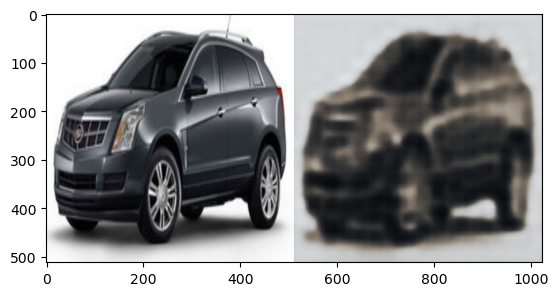

epoch:   5%|▍         | 1/22 [02:36<54:36, 156.04s/it]


Epoch 001 train_loss: 0.0292 


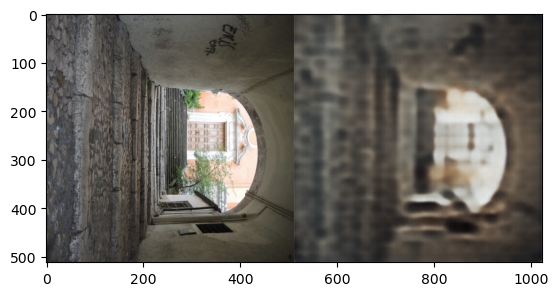

epoch:   9%|▉         | 2/22 [05:10<51:37, 154.86s/it]


Epoch 002 train_loss: 0.0168 


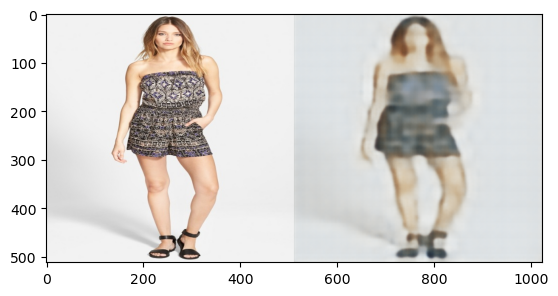

epoch:  14%|█▎        | 3/22 [07:43<48:48, 154.15s/it]


Epoch 003 train_loss: 0.0120 


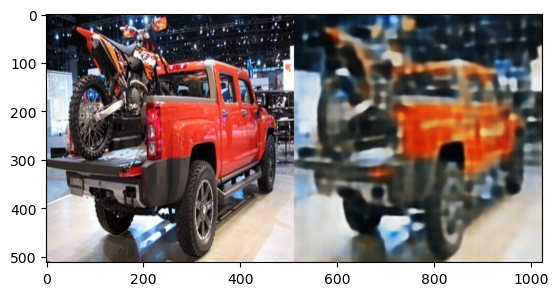

epoch:  18%|█▊        | 4/22 [10:16<46:10, 153.93s/it]


Epoch 004 train_loss: 0.0103 


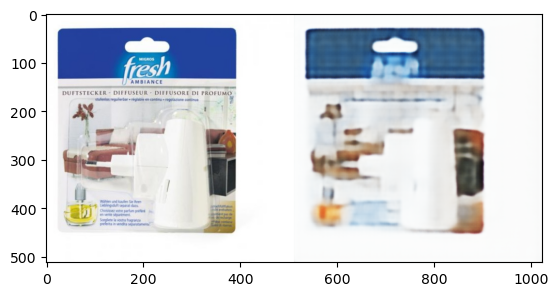

epoch:  23%|██▎       | 5/22 [12:50<43:36, 153.94s/it]


Epoch 005 train_loss: 0.0092 


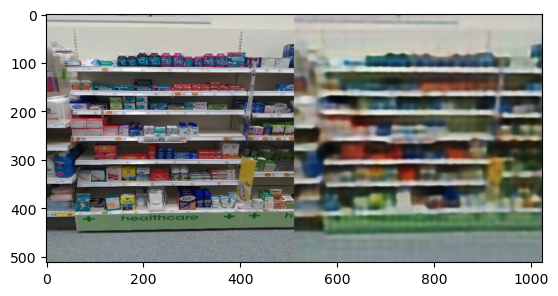

epoch:  27%|██▋       | 6/22 [15:24<41:03, 153.95s/it]


Epoch 006 train_loss: 0.0085 


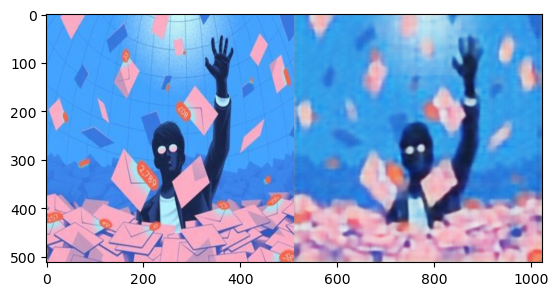

epoch:  32%|███▏      | 7/22 [17:58<38:27, 153.86s/it]


Epoch 007 train_loss: 0.0075 


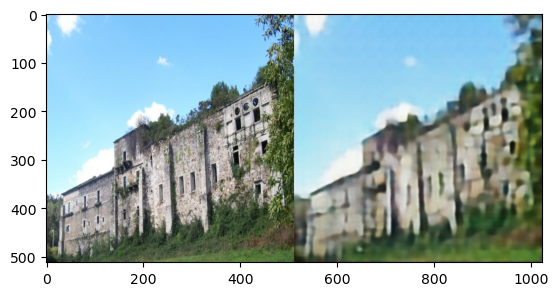

epoch:  36%|███▋      | 8/22 [20:32<35:52, 153.73s/it]


Epoch 008 train_loss: 0.0072 


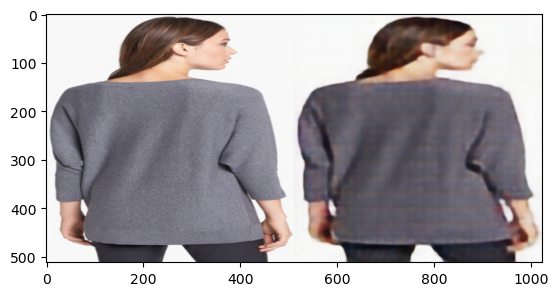

epoch:  41%|████      | 9/22 [23:06<33:19, 153.81s/it]


Epoch 009 train_loss: 0.0070 


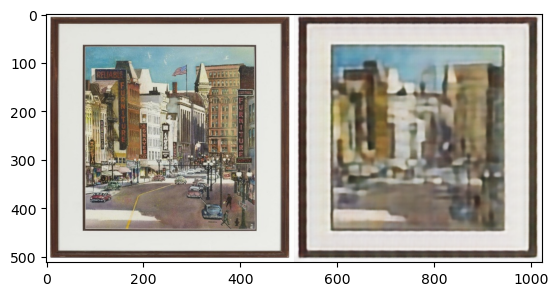

epoch:  45%|████▌     | 10/22 [25:40<30:46, 153.89s/it]


Epoch 010 train_loss: 0.0066 


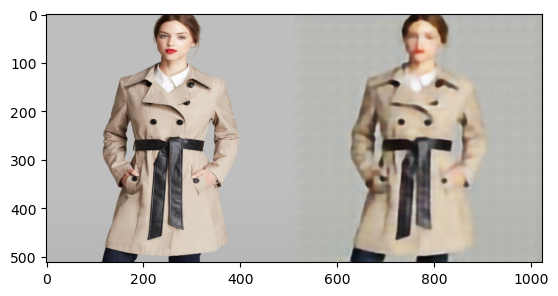

epoch:  50%|█████     | 11/22 [28:14<28:13, 153.95s/it]


Epoch 011 train_loss: 0.0061 


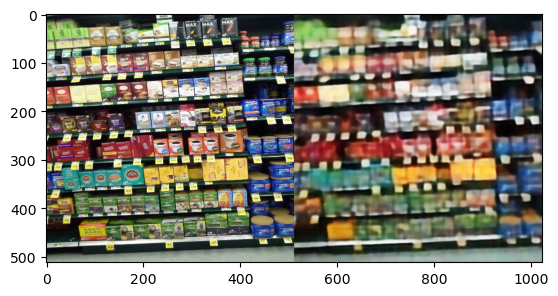

epoch:  55%|█████▍    | 12/22 [30:48<25:39, 153.94s/it]


Epoch 012 train_loss: 0.0059 


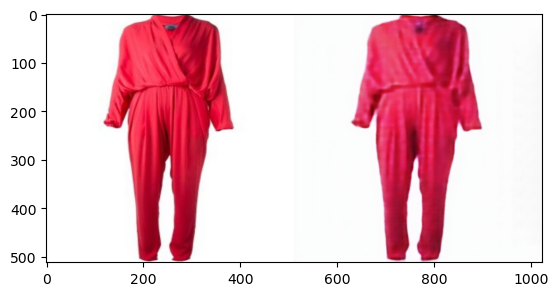

epoch:  59%|█████▉    | 13/22 [33:21<23:04, 153.86s/it]


Epoch 013 train_loss: 0.0057 


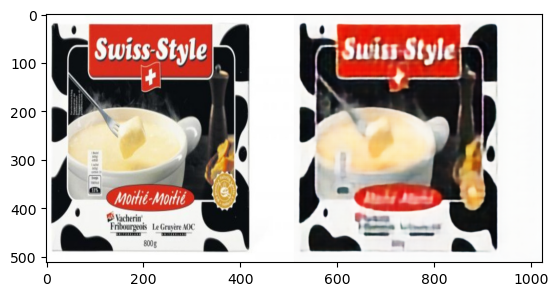

epoch:  64%|██████▎   | 14/22 [35:55<20:30, 153.83s/it]


Epoch 014 train_loss: 0.0054 


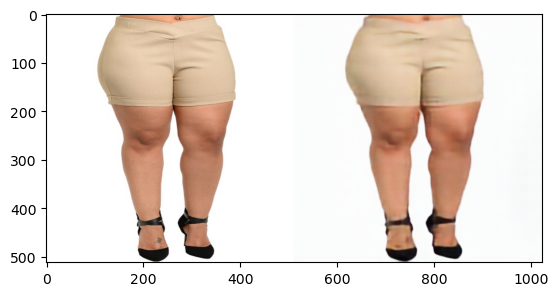

epoch:  68%|██████▊   | 15/22 [38:29<17:57, 153.97s/it]


Epoch 015 train_loss: 0.0052 


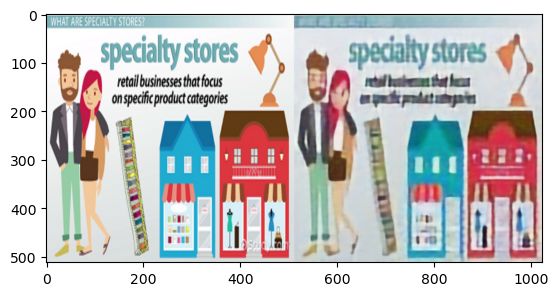

epoch:  73%|███████▎  | 16/22 [41:03<15:23, 153.98s/it]


Epoch 016 train_loss: 0.0050 


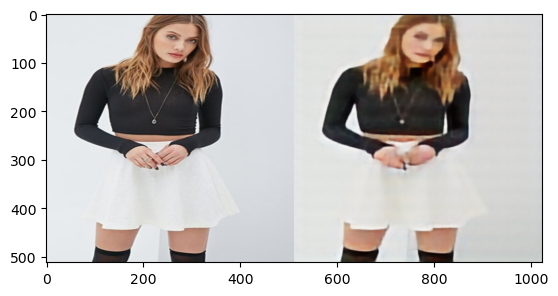

epoch:  77%|███████▋  | 17/22 [43:39<12:51, 154.37s/it]


Epoch 017 train_loss: 0.0049 


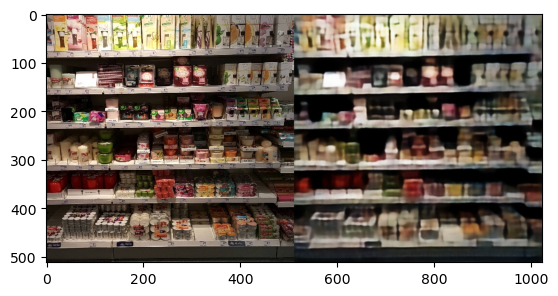

epoch:  82%|████████▏ | 18/22 [46:13<10:17, 154.32s/it]


Epoch 018 train_loss: 0.0049 


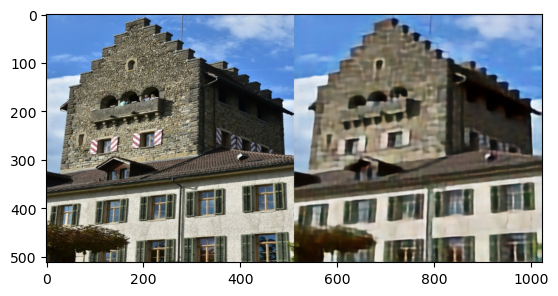

epoch:  86%|████████▋ | 19/22 [48:47<07:42, 154.19s/it]


Epoch 019 train_loss: 0.0046 


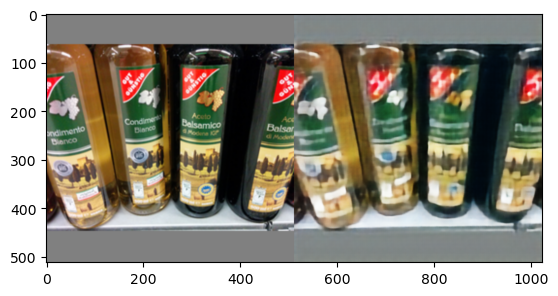

epoch:  91%|█████████ | 20/22 [51:20<05:07, 153.96s/it]


Epoch 020 train_loss: 0.0046 


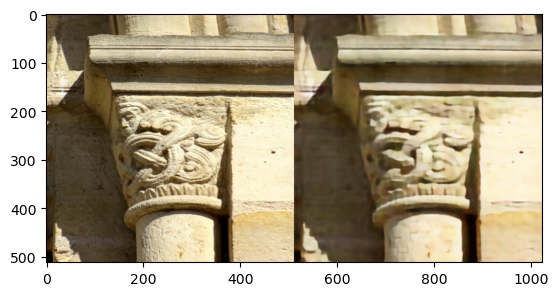

epoch:  95%|█████████▌| 21/22 [53:54<02:33, 153.81s/it]


Epoch 021 train_loss: 0.0045 


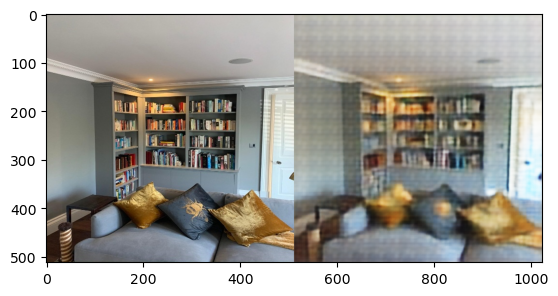

epoch: 100%|██████████| 22/22 [56:27<00:00, 153.97s/it]


Epoch 022 train_loss: 0.0073 


In [93]:
import torchvision
DEVICE = 'cuda'
B = 2
model = EncDec(B = B).to(DEVICE)
train_dataset = Dataset_maker(lst, mode='train')
train(train_dataset,model,22,32)

In [94]:
# сохранение весов кодера и декодера
torch.save(model.cpu().enc.state_dict(),f'encoder_weights_b{B}.pth')
torch.save(model.cpu().dec.state_dict(),f'decoder_weights_b{B}.pth')

In [95]:
def encoder_pipeline(image_path,B=2):
    encoder = Encoder(B)
    encoder.load_state_dict(torch.load(f'encoder_weights_b{B}.pth'))
    encoder.eval()
    image = Image.open(image_path).convert("RGB")
    image.load()
    image = np.array(image)
    plt.imshow(image)
    plt.show()
    image = image/255
    image = T.ToTensor()(image).float()
    image = image.reshape(1,3,512,512)
    res = encoder(image) # квантование входит в модель, остается только округлить
    res = torch.floor(res)
    # арифметическое кодирование 
    
    return res
    
def decoder_pipeline(compress_image, B):
    decoder = Decoder(B)
    decoder.load_state_dict(torch.load(f'decoder_weights_b{B}.pth'))
    decoder.eval()
    res = decoder(compress_image.float())
    res = torch.sigmoid(res).detach().cpu().numpy()
    plt.imshow(res[0].squeeze().transpose(1,2,0))
    plt.show()
    return res

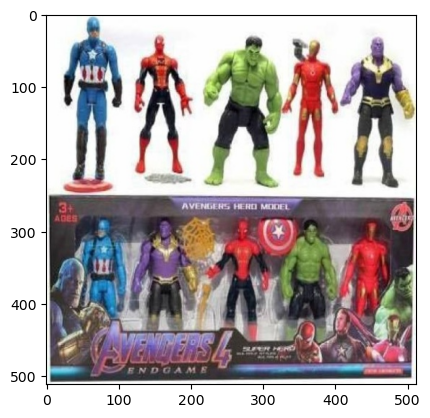

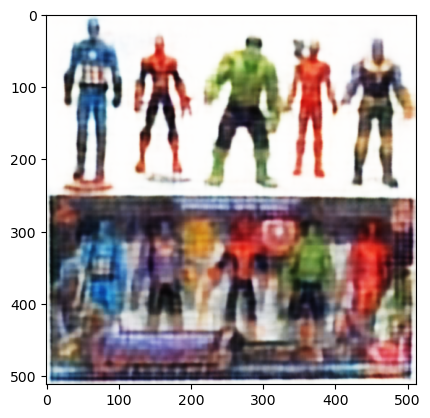

In [96]:
res = encoder_pipeline('/kaggle/input/130k-images-512x512-universal-image-embeddings/toys/image0001.jpeg', B=B)
res2 = decoder_pipeline(res,B)